# <b>AGN Percentages<b>
The ultimate goal of this notebook is to find what percentages of our AGN candidates have matches with known AGN in various other catalogues.

---

### Set-Up

In [1]:
# For passwords & database access:
import psycopg2
import psycopg2.extras
import getpass

# Import necessary packages
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
import shapely.wkt as wkt
from shapely.geometry import Point

In [2]:
# Logging in
dbuser = input("DB User: ")
dbpasswd = getpass.getpass("DB Password: ")
db = psycopg2.connect(f"dbname='decat' user='{dbuser}' password='{dbpasswd}' host='decatdb.lbl.gov'")

db.autocommit = True  # Makes the computer nicer about SQL syntax errors

cursor = db.cursor(cursor_factory = psycopg2.extras.DictCursor)

DB User:  midorr
DB Password:  ········


In [3]:
# Things in the database are tagged with versions, and everything that's in the database should be tagged with the "latest" tag (for now)
tag = "latest"  # Eventually we'll probably want to use "default"
db.rollback()
q = ("SELECT id,tag FROM versiontags WHERE tag=%(tag)s")
cursor.execute(q, {"tag": tag})
row = cursor.fetchone()
tagid = row['id']

### Querying RA & DEC of AGN from our database

In [4]:
%%time
# Retreive RA & DEC in COSMOS from our data
query_cosmos = ("SELECT od.ra, od.dec "
                "FROM objectdatas AS od "
                "INNER JOIN objectdata_versiontag AS odvt ON od.id=odvt.objectdata_id AND odvt.versiontag_id=%(tagid)s "
                "INNER JOIN objects AS o ON od.object_id=o.id "
                "INNER JOIN images AS i ON o.image_id=i.id "
                "INNER JOIN objectrbs as rbs ON od.id=rbs.objectdata_id AND rbs.rbtype_id=2 "
                "INNER JOIN exposures AS e ON i.exposure_id=e.id "
                "WHERE od.ra > 147.0 AND od.ra < 154.0 AND od.dec > 0 "  # isolating COSMOS field
                "AND rbs.rb > 0.6 "
                "AND (e.proposalid = '2021A-0113' OR e.proposalid = '2021B-0149' OR "
                "e.proposalid = '2022A-724693' OR e.proposalid = '2022B-762878') "
                "LIMIT 10000000")

cursor.execute(query_cosmos, {'tagid': tagid})
radecquery_cosmos = np.array(cursor.fetchall()).T
radecquery_cosmos = np.unique(radecquery_cosmos.T, axis=0).T

# Retreive RA & DEC in ELAIS from our data
query_elais = ("SELECT od.ra, od.dec "
               "FROM objectdatas AS od "
               "INNER JOIN objectdata_versiontag AS odvt ON od.id=odvt.objectdata_id AND odvt.versiontag_id=%(tagid)s "
               "INNER JOIN objects AS o ON od.object_id=o.id "
               "INNER JOIN images AS i ON o.image_id=i.id "
               "INNER JOIN objectrbs as rbs ON od.id=rbs.objectdata_id AND rbs.rbtype_id=2 "
               "INNER JOIN exposures AS e ON i.exposure_id=e.id "
               "WHERE od.ra > 5.0 AND od.ra < 12.0 AND od.dec > -46 AND od.dec < -41 "  # isolating ELAIS field
               "AND rbs.rb > 0.6 " 
               "AND (e.proposalid = '2021A-0113' OR e.proposalid = '2021B-0149' OR "
               "e.proposalid = '2022A-724693' OR e.proposalid = '2022B-762878') "
               "LIMIT 10000000")

cursor.execute(query_elais, {'tagid': tagid})
radecquery_elais = np.array(cursor.fetchall()).T
radecquery_elais = np.unique(radecquery_elais.T, axis=0).T

CPU times: user 2.36 s, sys: 237 ms, total: 2.6 s
Wall time: 1min 25s


### Making a simple polygon enclosing our field (short enough that its vertices fit in an ADQL query)

In [5]:
# Create polygon objects using all of the points as vertices

# COSMOS
polystr_cosmos = str([str(i[0])+" "+str(i[1]) for i in np.round(radecquery_cosmos.T,2)]).replace("'","")
pol_cosmos = wkt.loads("POLYGON (({}))".format(polystr_cosmos[1:-1]+', '+polystr_cosmos[1:12]))

# ELAIS
polystr_elais = str([str(i[0])+" "+str(i[1]) for i in np.round(radecquery_elais.T,2)]).replace("'","")
pol_elais = wkt.loads("POLYGON (({}))".format(polystr_elais[1:-1]+', '+polystr_elais[1:12]))

In [6]:
pol_cosmos

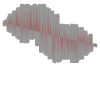

In [7]:
pol_elais

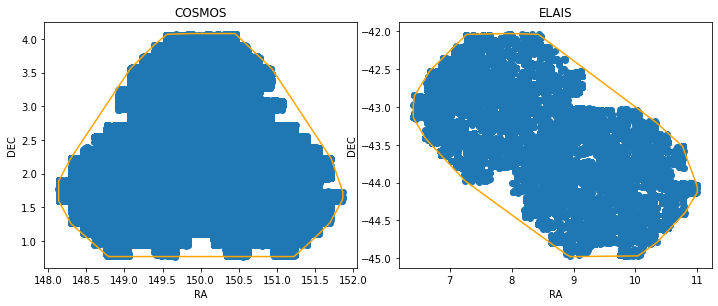

In [8]:
# Simplify the polygons to the simplest convex shape that encloses all data:
polconvhull_cosmos = pol_cosmos.convex_hull
polconvhull_elais = pol_elais.convex_hull
convhullarr_cosmos = polconvhull_cosmos.exterior.coords.xy
convhullarr_elais = polconvhull_elais.exterior.coords.xy

# Set up plots
fig, ax = plt.subplots(1,2) 
fig.set_size_inches(10,4)  
fig.tight_layout()

# Plot COSMOS/ELAIS data and simplest convex polygons enclosing all pts for both fields
ax[0].set_title("COSMOS")
ax[0].set_xlabel('RA')
ax[0].set_ylabel('DEC')
ax[0].scatter(*radecquery_cosmos)
ax[0].plot(convhullarr_cosmos[0],convhullarr_cosmos[1],color='orange') 

ax[1].set_title("ELAIS")
ax[1].set_xlabel('RA')
ax[1].set_ylabel('DEC')
ax[1].scatter(*radecquery_elais)
ax[1].plot(convhullarr_elais[0],convhullarr_elais[1],color='orange');

In [9]:
## Grabbed every AGN within that orange boundary from SIMBAD at http://simbad.u-strasbg.fr/simbad/sim-tap
## Used this query, saved as {field}_result.txt in this directory
## Just showing my work, the query results for all of the below are saved to this directory already
print("SELECT distinct main_id, ra, dec, otype_txt")
print("FROM basic")
print("WHERE otype = 'AGN..'") # 'AGN..' here means all subtypes of AGN (QSOs, seyferts, etc.)
print("AND CONTAINS(POINT('ICRS', ra, dec), POLYGON('ICRS', {})) = 1".format(str(list(np.array(convhullarr_cosmos).T.flatten()))[1:-1]))
print("GROUP BY main_id, otype_txt, ra, dec")

## SIMBAD ADQL queries used for the catalog-specific queries

# print("""
# SELECT distinct IDENT.id, basic.ra, basic.dec, basic.otype_txt
# FROM basic
# JOIN IDENT on IDENT.oidref=basic.oid
# WHERE basic.otype = 'AGN..'
# AND IDENT.id like 'ESIS%'
# AND CONTAINS(POINT('ICRS', basic.ra, basic.dec), POLYGON('ICRS', {})) = 1
# GROUP BY IDENT.id, basic.otype_txt, basic.ra, basic.dec
# """.format(str(list(np.array(convhullarr).T.flatten()))[1:-1]))

# """
# SELECT distinct IDENT.id, basic.ra, basic.dec, basic.otype_txt
# FROM basic
# JOIN IDENT on IDENT.oidref=basic.oid
# WHERE basic.otype = 'AGN..'
# AND IDENT.id like 'COSMOS2015%'
# AND CONTAINS(POINT('ICRS', basic.ra, basic.dec), POLYGON('ICRS', 150.6, 0.77, 148.79, 0.78, 148.3, 1.34, 148.15, 1.6, 148.15, 1.9, 148.32, 2.23, 149.08, 3.56, 149.26, 3.75, 149.57, 4.05, 150.21, 4.07, 150.44, 4.02, 150.91, 3.53, 151.69, 2.22, 151.85, 1.73, 151.85, 1.66, 151.84, 1.62, 151.7, 1.34, 151.53, 1.12, 151.39, 0.96, 151.22, 0.8, 151.18, 0.79, 151.0, 0.78, 150.6, 0.77)) = 1
# GROUP BY IDENT.id, basic.otype_txt, basic.ra, basic.dec
# """

# """
# SELECT distinct IDENT.id, basic.ra, basic.dec, basic.otype_txt
# FROM basic
# JOIN IDENT on IDENT.oidref=basic.oid
# WHERE basic.otype = 'AGN..'
# AND IDENT.id like 'ACS-GC%'
# AND CONTAINS(POINT('ICRS', basic.ra, basic.dec), POLYGON('ICRS', 150.6, 0.77, 148.79, 0.78, 148.3, 1.34, 148.15, 1.6, 148.15, 1.9, 148.32, 2.23, 149.08, 3.56, 149.26, 3.75, 149.57, 4.05, 150.21, 4.07, 150.44, 4.02, 150.91, 3.53, 151.69, 2.22, 151.85, 1.73, 151.85, 1.66, 151.84, 1.62, 151.7, 1.34, 151.53, 1.12, 151.39, 0.96, 151.22, 0.8, 151.18, 0.79, 151.0, 0.78, 150.6, 0.77)) = 1
# GROUP BY IDENT.id, basic.otype_txt, basic.ra, basic.dec
# """

# """
# SELECT distinct IDENT.id, basic.ra, basic.dec, basic.otype_txt
# FROM basic
# JOIN IDENT on IDENT.oidref=basic.oid
# WHERE basic.otype = 'AGN..'
# AND IDENT.id like 'SWIRE%'
# AND CONTAINS(POINT('ICRS', basic.ra, basic.dec), POLYGON('ICRS', 9.79, -44.98, 8.87, -44.97, 7.28, -43.98, 7.25, -43.96, 7.03, -43.81, 6.82, -43.65, 6.61, -43.48, 6.6, -43.47, 6.41, -43.15, 6.4, -43.07, 6.4, -42.95, 6.41, -42.88, 6.42, -42.86, 6.62, -42.52, 7.05, -42.19, 7.26, -42.04, 7.34, -42.03, 8.07, -42.03, 8.48, -42.04, 10.12, -43.02, 10.34, -43.19, 10.78, -43.53, 11.0, -44.03, 11.0, -44.11, 10.79, -44.47, 10.36, -44.81, 10.15, -44.97, 9.98, -44.98, 9.79, -44.98)) = 1
# GROUP BY IDENT.id, basic.otype_txt, basic.ra, basic.dec
# """;

SELECT distinct main_id, ra, dec, otype_txt
FROM basic
WHERE otype = 'AGN..'
AND CONTAINS(POINT('ICRS', ra, dec), POLYGON('ICRS', 148.8, 0.77, 148.78, 0.78, 148.45, 1.11, 148.3, 1.26, 148.14, 1.6, 148.14, 1.89, 148.3, 2.23, 149.08, 3.56, 149.23, 3.73, 149.39, 3.91, 149.56, 4.07, 149.89, 4.08, 150.44, 4.08, 150.46, 4.07, 150.93, 3.56, 151.71, 2.22, 151.86, 1.73, 151.86, 1.63, 151.85, 1.6, 151.69, 1.27, 151.55, 1.11, 151.39, 0.94, 151.22, 0.77, 148.8, 0.77)) = 1
GROUP BY main_id, otype_txt, ra, dec


In [10]:
# Define ID, RA, DEC, and TYPE of AGN in each catalogue

# COSMOS
fnm = 'COSMOS_result.txt'
cosmos_id = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={0}, dtype='str')
cosmos_ra = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={1}, dtype='float')
cosmos_dec = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={2}, dtype='float')
cosmos_type = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={3}, dtype='str')
cosmos_coords = np.array([cosmos_ra, cosmos_dec]).T

fnm = 'COSMOS2015_result.txt'
cosmos15_id = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={0}, dtype='str')
cosmos15_ra = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={1}, dtype='float')
cosmos15_dec = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={2}, dtype='float')
cosmos15_type = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={3}, dtype='str')
cosmos15_coords = np.array([cosmos15_ra, cosmos15_dec]).T

fnm = 'ACS-GC_result.txt'
acs_id = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={0}, dtype='str')
acs_ra = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={1}, dtype='float')
acs_dec = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={2}, dtype='float')
acs_type = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={3}, dtype='str')
acs_coords = np.array([acs_ra, acs_dec]).T

# ELAIS
fnm = 'ELAIS_result.txt'
elais_id = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={0}, dtype='str')
elais_ra = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={1}, dtype='float')
elais_dec = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={2}, dtype='float')
elais_type = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={3}, dtype='str')
elais_coords = np.array([elais_ra, elais_dec]).T


fnm = 'ESIS_result.txt'
esis_id = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={0}, dtype='str')
esis_ra = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={1}, dtype='float')
esis_dec = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={2}, dtype='float')
esis_type = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={3}, dtype='str')
esis_coords = np.array([esis_ra, esis_dec]).T

fnm = 'SWIRE_result.txt'
swire_id = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={0}, dtype='str')
swire_ra = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={1}, dtype='float')
swire_dec = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={2}, dtype='float')
swire_type = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={3}, dtype='str')
swire_coords = np.array([swire_ra, swire_dec]).T

In [11]:
# Now have coords for every AGN in the orange boundary (this includes things outside our fields still)
esis_coords[:5]  # example of coords from our ESIS catalogue

array([[  8.45583333, -43.38527778],
       [  8.35625   , -43.36916667],
       [  8.47333333, -43.35777778],
       [  8.29208333, -43.35138889],
       [  8.46208333, -43.35222222]])

### Drawing a tighter polygon around our fields, excluding SIMBAD AGN from outside that region

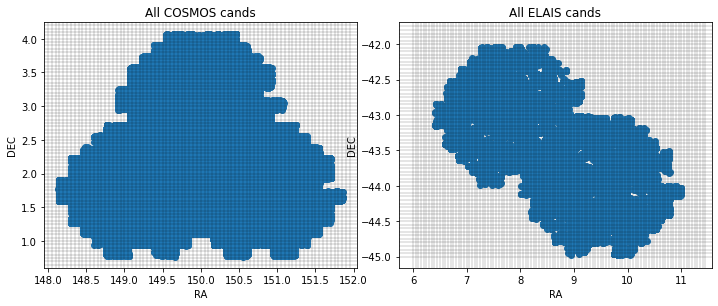

In [12]:
# Create a stricter boundary now that we have the raw data:
# I do this by making a grid and labelling each rectangle as 'containing data' or not 
# (if I don't condense the data like this, making the polygon gets computationally prohibitive)

prec=0.05   # Polygon parameter

# Set up plots
fig, ax = plt.subplots(1,2) 
fig.set_size_inches(10,4)  
fig.tight_layout()

# Plot COSMOS data
ax[0].set_title("All COSMOS cands")
ax[0].set_xlabel('RA')
ax[0].set_ylabel('DEC')
ax[0].scatter(*radecquery_cosmos)

ys_cosmos = np.arange(0.65,4.25,prec) # COSMOS
xs_cosmos = np.arange(148,152,prec) # COSMOS
xys_cosmos = np.meshgrid(xs_cosmos,ys_cosmos) # COSMOS

# Plot ELAIS data
ax[1].set_title("All ELAIS cands")
ax[1].set_xlabel('RA')
ax[1].set_ylabel('DEC')
ax[1].scatter(*radecquery_elais)

# Get locations of points
ys_elais = np.arange(-45.0,-41.7,prec) # ELAIS
xs_elais = np.arange(6,11.5,prec) # ELAIS
xys_elais = np.meshgrid(xs_elais,ys_elais) # ELAIS


# Plot grid lines on the
for i in ys_cosmos:
    ax[0].axhline(i, color='black',lw=0.2)
for i in xs_cosmos:
    ax[0].axvline(i, color='black',lw=0.2)
for i in ys_elais:
    ax[1].axhline(i, color='black',lw=0.2)
for i in xs_elais:
    ax[1].axvline(i, color='black',lw=0.2)

In [13]:
# COSMOS
good_cosmos = []
for i in range(len(xs_cosmos)):
    for j in range(len(ys_cosmos)):
        data = radecquery_cosmos[0][np.where((radecquery_cosmos[0]<xs_cosmos[i]+prec) & (radecquery_cosmos[0]>xs_cosmos[i]) \
                                      & (radecquery_cosmos[1]<ys_cosmos[j]+prec) & (radecquery_cosmos[1]>ys_cosmos[j]))[0]]
        if len(data) > 0:
            good_cosmos.append([i,j])
goodidx_cosmos = np.array(good_cosmos).transpose()
goodxs_cosmos = xs_cosmos[goodidx_cosmos[0]] + prec/2 # Center coordinate within grid box
goodys_cosmos = ys_cosmos[goodidx_cosmos[1]] + prec/2 # Center coordinate within grid box
goods_cosmos = np.array([goodxs_cosmos,goodys_cosmos])

# ELAIS
good_elais = []
for i in range(len(xs_elais)):
    for j in range(len(ys_elais)):
        data = radecquery_elais[0][np.where((radecquery_elais[0]<xs_elais[i]+prec) & (radecquery_elais[0]>xs_elais[i]) \
                                      & (radecquery_elais[1]<ys_elais[j]+prec) & (radecquery_elais[1]>ys_elais[j]))[0]]
        if len(data) > 0:
            good_elais.append([i,j])
goodidx_elais = np.array(good_elais).transpose()
goodxs_elais = xs_elais[goodidx_elais[0]] + prec/2 # Center coordinate within grid box
goodys_elais = ys_elais[goodidx_elais[1]] + prec/2 # Center coordinate within grid box
goods_elais = np.array([goodxs_elais,goodys_elais])

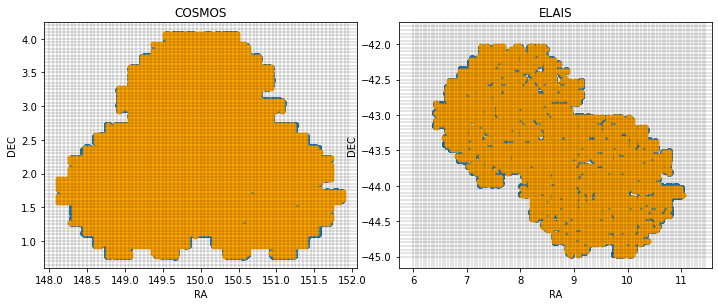

In [14]:
fig, ax = plt.subplots(1,2) 
fig.set_size_inches(10,4)  
fig.tight_layout()

#COSMOS
ax[0].set_title("COSMOS")
ax[0].set_xlabel('RA')
ax[0].set_ylabel('DEC')
ax[0].scatter(*radecquery_cosmos)
ax[0].scatter(*goods_cosmos,lw=0.05, color='orange')

for i in ys_cosmos:
    ax[0].axhline(i, color='black',lw=0.2)
for i in xs_cosmos:
    ax[0].axvline(i, color='black',lw=0.2)
    
#ELAIS
ax[1].set_title("ELAIS")
ax[1].set_xlabel('RA')
ax[1].set_ylabel('DEC')
ax[1].scatter(*radecquery_elais)
ax[1].scatter(*goods_elais,lw=0.05, color='orange')

for i in ys_elais:
    ax[1].axhline(i, color='black',lw=0.2)
for i in xs_elais:
    ax[1].axvline(i, color='black',lw=0.2)

In [15]:
pol2str_cosmos = str([str(i[0])+" "+str(i[1]) for i in np.round(goods_cosmos.T,2)]).replace("'","")
pol2_cosmos = wkt.loads("POLYGON (({}))".format(pol2str_cosmos[1:-1]+', '+pol2str_cosmos[1:12])) # COSMOS

pol2str_elais = str([str(i[0])+" "+str(i[1]) for i in np.round(goods_elais.T,2)]).replace("'","")
pol2_elais = wkt.loads("POLYGON (({}))".format(pol2str_elais[1:-1]+', '+pol2str_elais[1:12])) # ELAIS

pol3_cosmos = pol2_cosmos.buffer(prec)
pol3_elais = pol2_elais.buffer(prec)
pol3arr_cosmos = pol3_cosmos.exterior.coords.xy
pol3arr_elais = pol3_elais.exterior.coords.xy

In [16]:
%%time

#COSMOS

cosmos_msk = []
for coord in cosmos_coords:
    pt = Point(coord[0],coord[1])
    cosmos_msk.append(pt.within(pol3_cosmos))
cosmos_coords1 = cosmos_coords[cosmos_msk]
cosmos_id1 = cosmos_id[cosmos_msk]
cosmos_type1 = cosmos_type[cosmos_msk]

cosmos15_msk = []
for coord in cosmos15_coords:
    pt = Point(coord[0],coord[1])
    cosmos15_msk.append(pt.within(pol3_cosmos))
cosmos15_coords1 = cosmos15_coords[cosmos15_msk]
cosmos15_id1 = cosmos15_id[cosmos15_msk]
cosmos15_type1 = cosmos15_type[cosmos15_msk]

acs_msk = []
for coord in acs_coords:
    pt = Point(coord[0],coord[1])
    acs_msk.append(pt.within(pol3_cosmos))
acs_coords1 = acs_coords[acs_msk]
acs_id1 = acs_id[acs_msk]
acs_type1 = acs_type[acs_msk]


# ELAIS

elais_msk = []
for coord in elais_coords:
    pt = Point(coord[0],coord[1])
    elais_msk.append(pt.within(pol3_elais))
elais_coords1 = elais_coords[elais_msk]
elais_id1 = elais_id[elais_msk]
elais_type1 = elais_type[elais_msk]

esis_msk = []
for coord in esis_coords:
    pt = Point(coord[0],coord[1])
    esis_msk.append(pt.within(pol3_elais))
esis_coords1 = esis_coords[esis_msk]
esis_id1 = esis_id[esis_msk]
esis_type1 = esis_type[esis_msk]

swire_msk = []
for coord in swire_coords:
    pt = Point(coord[0],coord[1])
    swire_msk.append(pt.within(pol3_elais))
swire_coords1 = swire_coords[swire_msk]
swire_id1 = swire_id[swire_msk]
swire_type1 = swire_type[swire_msk]

CPU times: user 8.77 s, sys: 3.14 ms, total: 8.77 s
Wall time: 8.77 s


In [17]:
len(cosmos_coords), len(cosmos_coords1)

(47081, 46893)

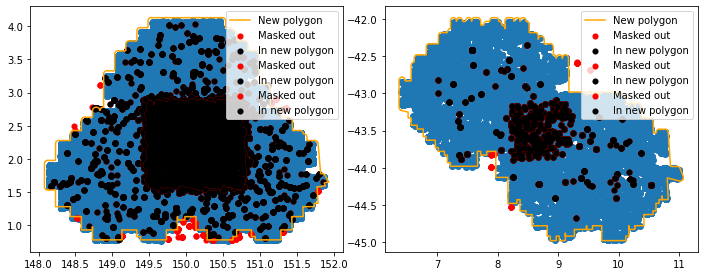

In [18]:
fig, ax = plt.subplots(1,2) 
fig.set_size_inches(10,4)  
fig.tight_layout()

# COSMOS

ax[0].scatter(*radecquery_cosmos)
ax[0].plot(*pol3arr_cosmos, color='orange',label="New polygon")
ax[0].scatter(*cosmos_coords.T,color='red', lw=0.1, label="Masked out")
ax[0].scatter(*cosmos_coords1.T,color='black', lw=0.1, label="In new polygon")
ax[0].scatter(*cosmos15_coords.T,color='red', lw=0.1, label="Masked out")
ax[0].scatter(*cosmos15_coords1.T,color='black', lw=0.1, label="In new polygon")
ax[0].scatter(*acs_coords.T,color='red', lw=0.1, label="Masked out")
ax[0].scatter(*acs_coords1.T,color='black', lw=0.1, label="In new polygon")
ax[0].legend(loc='upper right')

# ELAIS

ax[1].scatter(*radecquery_elais)
ax[1].plot(*pol3arr_elais, color='orange',label="New polygon")
ax[1].scatter(*elais_coords.T,color='red', lw=0.1, label="Masked out")
ax[1].scatter(*elais_coords1.T,color='black', lw=0.1, label="In new polygon")
ax[1].scatter(*esis_coords.T,color='red', lw=0.1, label="Masked out")
ax[1].scatter(*esis_coords1.T,color='black', lw=0.1, label="In new polygon")
ax[1].scatter(*swire_coords.T,color='red', lw=0.1, label="Masked out")
ax[1].scatter(*swire_coords1.T,color='black', lw=0.1, label="In new polygon")
ax[1].legend(loc='upper right');

##### So now we have all of the known AGN we could theoretically detect in our field
Next step is to match them up to "probably-real" candidates

### Matching up all known AGN we could theoretically detect in our fields to "probably-real" candidates

In [19]:
### Grab all cand names for 'probably-real' cands
realcandsarr = np.genfromtxt('../extragalactic_fields/candidate_nightly_epochs_files/candidate_lightcurve_parameters.dat', dtype=str)
realcands = np.unique(realcandsarr.T[1])

In [ ]:
### Find coords and make SkyCoord objects for all candidates:
candcoord = []
for i in realcands:
    query = ("SELECT c.ra, c.dec FROM candidates c "
             "WHERE c.id = %s "
             "LIMIT 1")
    cursor.execute(query,(i,))
    res = np.array(cursor.fetchall())[0]
    candcoord.append([i,res])
candcoord1 = np.array([[i[0], SkyCoord(i[1][0],i[1][1], unit='deg')] for i in candcoord])

In [ ]:
### Make a catalog-style set of SkyCoords for the SIMBAD sample

# COSMOS
cosmos_coords2 = SkyCoord(cosmos_coords1,unit='deg')
cosmos15_coords2 = SkyCoord(cosmos15_coords1,unit='deg')
acs_coords2 = SkyCoord(acs_coords1,unit='deg')

#ELAIS
elais_coords2 = SkyCoord(elais_coords1,unit='deg')
esis_coords2 = SkyCoord(esis_coords1,unit='deg')
swire_coords2 = SkyCoord(swire_coords1,unit='deg')

In [ ]:
%%time
### Match the datasets with a 2 arcsec radius

# COSMOS

cosmos_matches = []
for i, coord in enumerate(candcoord1.T[1]):
    idx, sep2d, dist3d = coord.match_to_catalog_sky(cosmos_coords2)
    if sep2d < 2*u.arcsec:
        cosmos_matches.append([i,coord,idx, sep2d])
cosmos_matches = np.array(cosmos_matches)

cosmos15_matches = []
for i, coord in enumerate(candcoord1.T[1]):
    idx, sep2d, dist3d = coord.match_to_catalog_sky(cosmos15_coords2)
    if sep2d < 2*u.arcsec:
        cosmos15_matches.append([i,coord,idx, sep2d])
cosmos15_matches = np.array(cosmos15_matches)

acs_matches = []
for i, coord in enumerate(candcoord1.T[1]):
    idx, sep2d, dist3d = coord.match_to_catalog_sky(acs_coords2)
    if sep2d < 2*u.arcsec:
        acs_matches.append([i,coord,idx, sep2d])
acs_matches = np.array(acs_matches)


# ELAIS

elais_matches = []
for i, coord in enumerate(candcoord1.T[1]):
    idx, sep2d, dist3d = coord.match_to_catalog_sky(elais_coords2)
    if sep2d < 2*u.arcsec:
        elais_matches.append([i,coord,idx, sep2d])
elais_matches = np.array(elais_matches)

esis_matches = []
for i, coord in enumerate(candcoord1.T[1]):
    idx, sep2d, dist3d = coord.match_to_catalog_sky(esis_coords2)
    if sep2d < 2*u.arcsec:
        esis_matches.append([i,coord,idx, sep2d])
esis_matches = np.array(esis_matches)

swire_matches = []
for i, coord in enumerate(candcoord1.T[1]):
    idx, sep2d, dist3d = coord.match_to_catalog_sky(swire_coords2)
    if sep2d < 2*u.arcsec:
        swire_matches.append([i,coord,idx, sep2d])
swire_matches = np.array(swire_matches)

#### Printing the percentages of known agn matched to our agn candidates

In [ ]:
### Display percentages matched for COSMOS
cosmos_matchmsk = cosmos_matches.T[2].astype(int)
cosmos15_matchmsk = cosmos15_matches.T[2].astype(int)
acs_matchmsk = acs_matches.T[2].astype(int)

cosmos_coordsmatched = cosmos_coords1[cosmos_matchmsk]
cosmos15_coordsmatched = cosmos15_coords1[cosmos15_matchmsk]
acs_coordsmatched = acs_coords1[acs_matchmsk]

cosmos_typesmatched = cosmos_type1[cosmos_matchmsk]
cosmos15_typesmatched = cosmos15_type1[cosmos15_matchmsk]
acs_typesmatched = acs_type1[acs_matchmsk]

cosmos_idmatched = cosmos_id1[cosmos_matchmsk]
cosmos15_idmatched = cosmos15_id1[cosmos15_matchmsk]
acs_idmatched = acs_id1[acs_matchmsk]

print("For the COSMOS field:")

print("\nUsing this file: ./COSMOS_result.txt")
for typee in np.unique(cosmos_type):
    cosmos_msk = np.where(cosmos_typesmatched==typee)[0]
    cosmos_nummatched = len(cosmos_idmatched[cosmos_msk])
    try:
        cosmos_numtot = len(cosmos_id1[cosmos_type1==typee])
        cosmos_perc = np.round(cosmos_nummatched/cosmos_numtot*100,2)
        print("found {} out of {} {} ({} %)".format(cosmos_nummatched, cosmos_numtot,typee,cosmos_perc))
        #print(f"found {cosmos_nummatched} out of {cosmos_numtot} {typee} ({cosmos_nummatched/cosmos_numtot*100:.2f} %)")
    except:
        pass
print("We detected {} known agn as 'probably-real' candidates, out of {} known agn".format(len(cosmos_matches), len(cosmos_coords1)))
print("This represents {} % of all the known agn in our field".format(np.round(len(cosmos_matches)/len(cosmos_coords1)*100,2)))

print("\nUsing this file: ./COSMOS2015_result.txt")
for typee in np.unique(cosmos15_type):
    cosmos15_msk = np.where(cosmos15_typesmatched==typee)[0]
    cosmos15_nummatched = len(cosmos15_idmatched[cosmos15_msk])
    try:
        cosmos15_numtot = len(cosmos15_id1[cosmos15_type1==typee])
        cosmos15_perc = np.round(cosmos15_nummatched/cosmos15_numtot*100,2)
        print("found {} out of {} {} ({} %)".format(cosmos15_nummatched, cosmos15_numtot,typee,cosmos15_perc))
    except:
        pass
print("We detected {} known agn as 'probably-real' candidates, out of {} known agn".format(len(cosmos15_matches), len(cosmos15_coords1)))
print("This represents {} % of all the known agn in our field".format(np.round(len(cosmos15_matches)/len(cosmos15_coords1)*100,2)))

print("\nUsing this file: ./ACS-GC_result.txt")
for typee in np.unique(acs_type):
    acs_msk = np.where(acs_typesmatched==typee)[0]
    acs_nummatched = len(acs_idmatched[acs_msk])
    try:
        acs_numtot = len(acs_id1[acs_type1==typee])
        acs_perc = np.round(acs_nummatched/acs_numtot*100,2)
        print("found {} out of {} {} ({} %)".format(acs_nummatched, acs_numtot,typee,acs_perc))
    except:
        pass
print("We detected {} known agn as 'probably-real' candidates, out of {} known agn".format(len(acs_matches), len(acs_coords1)))
print("This represents {} % of all the known agn in our field".format(np.round(len(acs_matches)/len(acs_coords1)*100,2)))

In [ ]:
### Display percentages matched for ELAIS

elais_matchmsk = elais_matches.T[2].astype(int)
esis_matchmsk = esis_matches.T[2].astype(int)
swire_matchmsk = swire_matches.T[2].astype(int)

elais_coordsmatched = elais_coords1[elais_matchmsk]
esis_coordsmatched = esis_coords1[esis_matchmsk]
swire_coordsmatched = swire_coords1[swire_matchmsk]

elais_typesmatched = elais_type1[elais_matchmsk]
esis_typesmatched = esis_type1[esis_matchmsk]
swire_typesmatched = swire_type1[swire_matchmsk]

elais_idmatched = elais_id1[elais_matchmsk]
esis_idmatched = esis_id1[esis_matchmsk]
swire_idmatched = swire_id1[swire_matchmsk]

print("For the ELAIS field:")

print("\nUsing this file: ./ELAIS_result.txt")
for typee in np.unique(elais_type):
    elais_msk = np.where(elais_typesmatched==typee)[0]
    elais_nummatched = len(elais_idmatched[elais_msk])
    try:
        elais_numtot = len(elais_id1[elais_type1==typee])
        elais_perc = np.round(elais_nummatched/elais_numtot*100,2)
        print("found {} out of {} {} ({} %)".format(elais_nummatched, elais_numtot,typee,elais_perc))
        #print(f"found {elais_nummatched} out of {elais_numtot} {typee} ({elais_perc} %)")
    except:
        pass
print("We detected {} known agn as 'probably-real' candidates, out of {} known agn".format(len(elais_matches), len(elais_coords1)))
print("This represents {} % of all the known agn in our field".format(np.round(len(elais_matches)/len(elais_coords1)*100,2)))

print("\nUsing this file: ./ESIS_result.txt")
for typee in np.unique(esis_type):
    esis_msk = np.where(esis_typesmatched==typee)[0]
    esis_nummatched = len(esis_idmatched[esis_msk])
    try:
        esis_numtot = len(esis_id1[esis_type1==typee])
        esis_perc = np.round(esis_nummatched/esis_numtot*100,2)
        print("found {} out of {} {} ({} %)".format(esis_nummatched, esis_numtot,typee,esis_perc))
    except:
        pass
print("We detected {} known agn as 'probably-real' candidates, out of {} known agn".format(len(esis_matches), len(esis_coords1)))
print("This represents {} % of all the known agn in our field".format(np.round(len(esis_matches)/len(esis_coords1)*100,2)))

print("\nUsing this file: ./SWIRE_result.txt")
for typee in np.unique(swire_type):
    swire_msk = np.where(swire_typesmatched==typee)[0]
    swire_nummatched = len(swire_idmatched[swire_msk])
    try:
        swire_numtot = len(swire_id1[swire_type1==typee])
        swire_perc = np.round(swire_nummatched/swire_numtot*100,2)
        print("found {} out of {} {} ({} %)".format(swire_nummatched, swire_numtot,typee,swire_perc))
    except:
        pass
print("We detected {} known agn as 'probably-real' candidates, out of {} known agn".format(len(swire_matches), len(swire_coords1)))
print("This represents {} % of all the known agn in our field".format(np.round(len(swire_matches)/len(swire_coords1)*100,2)))